<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/ants_vs_bees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will train a ConvNet to classify ants and bees using [Hymenoptera](https://www.kaggle.com/datasets/thedatasith/hymenoptera) dataset. The dataset has 120 images each for ants and bees and 75 validation images for each class.

The process will be broken down into the following steps:

  1. Load and visualize the dataset
  2. Define a pre-trained model
      * Load in a pre-trained model
      * Freeze all the parameters, so that the network acts as a fixed feature extractor
      * Remove the last layer
      * Replace the last layer with a linear classifier 
  3. Define a loss function and optimizer
  4. Train the model on the training dataset
  5. Evaluate the performance of the trained model on the test dataset

In [2]:
# upload kaggle API key from you local machine
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shazzadraihan","key":"96c107c9376e84d48cd954b519ce7c9b"}'}

In [3]:
# make a kaggle dir, copy the API key to it 
# and make sure the file is only readable by yourself (chmod 600)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# use API command to download the dataset
!kaggle datasets download -d thedatasith/hymenoptera

 83% 38.0M/45.6M [00:00<00:00, 94.8MB/s]
100% 45.6M/45.6M [00:00<00:00, 82.9MB/s]


In [5]:
# uncompress the dataset
!unzip -qq hymenoptera.zip

In [6]:
# import required libraries
import torch
import torchvision

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# check if cuda in available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available")
else:
  print("CUDA is available")

device = torch.device("cuda") if train_on_gpu else torch.device("cpu")

CUDA is available


### Load and visualize the dataset

In [8]:
# define training and validation data directories
data_dir = "/content/hymenoptera/"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, 'val')

In [9]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# load and transform data using ImageFolder

data_transform = transforms.Compose([
          transforms.RandomResizedCrop(244), # Efficient B0 takes 244x244 images as input
          transforms.RandomHorizontalFlip(), # horizontally flip images (randomly)
          transforms.RandomRotation(10),     # rotate by 10 degree (randomly)
          transforms.ToTensor(), # convert to torch.FloatTensor
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize
          ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)

# print out some data stats
print("Number of training images: ", len(train_data))
print("Number of validation images: ", len(valid_data))

Number of training images:  244
Number of validation images:  153


In [10]:
# define dataloader parameters

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 4

# prepare train and validation data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# image classes in the dataset
classes = train_data.classes
print(classes)

['ants', 'bees']


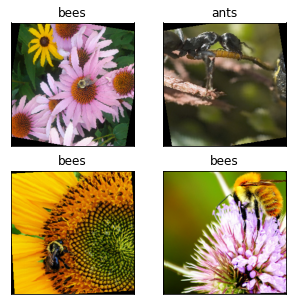

In [11]:
# visualize a batch of training data

def imshow(img):
  # unnormalize
  img = np.transpose(img, (1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)

# obtain one batch on training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy() 

# plot the images in the batch along with the corresponding labels
fig = plt.figure(figsize=(5,5))
# display 10 images
for ind in np.arange(4):
  ax = fig.add_subplot(2, 4/2, ind+1, xticks=[], yticks=[])
  imshow(images[ind])
  ax.set_title(classes[labels[ind]])

### Define a pre-trained model

In [12]:
from torchvision import models

# load a pre-trained model
model = models.efficientnet_b0(pretrained=True)

# print out the model stracture
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [13]:
print(model.classifier[1].in_features)
print(model.classifier[1].out_features)

1280
1000


In [14]:
# Freeze training for all features layers, so that the network acts as a fixed feature extractor
for param in model.parameters():
  param.requires_grad = False

In [17]:
import torch.nn as nn

num_inputs = model.classifier[1].in_features
last_layer = nn.Linear(num_inputs, len(classes))
model.classifier[1] = last_layer

# move model to the right device
model.to(device)

print(model.classifier[1].out_features)

2


### Define a loss function and optimizer

In [15]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss() # categorical cross-entropy

# specify optimizer
params = model.parameters()
optimizer = optim.SGD(params, lr=0.001, momentum=0.9) # SGD with momentum
